<p align="center"><img src="imgs/7-23.png" width=600></p>

위의 계층들을 순서대로 코드로 구현해보면 된다.

In [31]:
from common.util import im2col
import numpy as np

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape # 필터개수, 채널, 필터높이, 필터너비
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH)/self.stride)
        out_w = int(1 + (W + 2*self.pad - FW)/self.stride)
        print('out_h:', out_h)
        print('out_w:', out_w)

        col = im2col(x, FH, FW, self.stride, self.pad)
        print('col shape:', col.shape)
        col_W = self.W.reshape(FN, -1).T # 필터전개
        print('col_W shape:', col_W.shape)
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        return out

convoluiton을 하나씩 뜯어보기 위해, 이미지를 아무거나 하나 넣어보자.

(300, 300, 3)


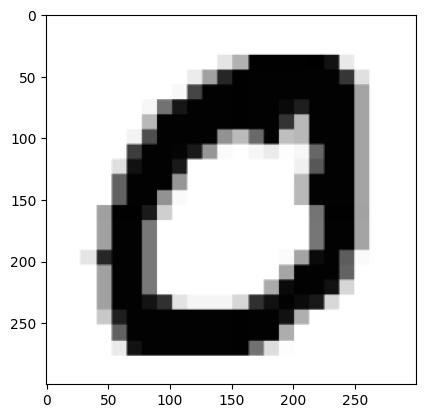

(1, 3, 300, 300)


In [32]:
import cv2
import matplotlib.pyplot as plt
x = cv2.imread('imgs/zero.png')
x = cv2.resize(x, (300, 300))

print(x.shape)
plt.imshow(x)
plt.show()

x = x.transpose(2, 0, 1)
x = np.expand_dims(x, axis=0) # 차원 수를 늘려줌 (convolution에 넣기 위해)
print(x.shape)

* opencv에서 이미지를 읽어오면 (H, W, C) 순으로 들어가는데, 책에서는 (C, H, W) 순으로 설명한다.
* 배치 처리를 하므로, 항상 shape의 맨 앞은 N (이미지 개수)
* 왜 W + b 모양이 다른데 연산이 가능할까? -> 실제로는 bias가 broadcast 되기 때문

In [36]:
W = np.array([2]*300).reshape(1, 3, 10, 10) # N, C, FH, FW
b = np.array([1]*3).reshape(3, 1, 1)

conv = Convolution(W, b)
out = conv.forward(x)
print(1 * 291 * 291) # out_h x out_w
print('out shape:', out.shape) # 곱셈이 왜 동작하는지 shape를 중점적으로 살펴볼 것

out_h: 291
out_w: 291
col shape: (84681, 300)
col_W shape: (300, 1)
84681
out shape: (1, 3, 291, 291)


im2col이 정확히 어떤 원리로 작동하는지는 모르지만.. 몇 가지 알게된 사실이 있다.

* im2col의 목적은 행렬의 곱셈을 위한 것이다. (곱셈을 편하게 하려고 펼쳐주는 역할)
* 각각의 원소들은 모두 input으로부터 오는 것이다. (별도의 곱셈, 다른 행렬 개입 안 함)
* output shape를 살펴보면, 첫 번째 차원은 output_shape와 관련이 있고, <br> 두번째 차원은 weight의 차원과 관련이 있다. (여기서 weight는 kernel/filter와 동일 의미로 쓰임)

정리: convolution의 forward를 거치게 되면, 이미지와 필터의 연산 결과가 나온다. (패딩까지 거친 것)